# 2023 영화

In [1]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

In [2]:
df = pd.read_csv('./data_movie/2023년 개봉작.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20230105,2023년 개봉 예정 영화 정리 개봉작 라인업 마블 새해가 밝고도 이제 5일 지난 ...,2023년 개봉 예정 영화 정리 개봉작 라인업 마블 새해가 밝고도 이제 5일 지난 ...,2023년 개봉 예정 영화 정리 개봉작 라인업 마블
1,20240504,"더 마블스 감독 니아 다코스타 출연 브리 라슨, 테요나 패리스, 이만 벨라니, 자웨...",마블 영화 더 마블스가 데드라인 선정 <b>2023년 개봉작<\/b> 최고 흥행 실...,마블 영화 더 마블스 2023년 영화 개봉작 흥행 실패 1위 선정
2,20231225,"*이번 주 추천작은 올해 영화 베스트 10, 올해 넷플릭스 베스트 10으로 대체합니...",<b>2023년<\/b>은 <b>개봉작<\/b> 베스트를 꼽는 게 다소 어려웠다. ...,2023년 올해의 영화 베스트 10 (국내 개봉작)
3,20231202,오늘은 2023년 12월 메가박스 돌비시네마 개봉작에 관한 글을 적어볼까 합니다. ...,"<b>2023년<\/b> 12월 6일 <b>개봉작<\/b>: 나폴레옹, 듄: Par...",2023년 12월 메가박스 돌비시네마 포맷 개봉작 소개
4,20230811,안녕하세요. 대중문화평론가를 꿈꿨으나 잦은 맞춤법 실수로 동네 평론가로 지내고 있는...,이런 건 다음에 얘기하고 ㅋㅋㅋㅋ 암튼 올여름 <b>개봉작<\/b> 5편 봐 보지 ...,2023년 여름 극장가 개봉작 봐 or 보지 마 결정해 드립니다.


## 1. 전처리

In [3]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [4]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = [
'개봉작', '2023년', '영화', '개봉', '감독', '작품', '수익', '관객', '배우', '출연', '박스오피스',
'이야기', '관람', '한국', '흥행', '누적', '기록', '국내', '주연', '예정', '액션', '생각', '극장',
'시리즈', '상영', '연출', '사람', '연기', '시작', '드라마', '대비', '소개', '출처', '순위', '올해',
'정보', '공개', '개봉일', '최고', '신규', '추천', '후기', '출연진', '주차', '신작', '제목', '연속',
'리뷰', '순위', '상영', '줄거리', '평점', '결산', '정리', '돌파', '작품', '주말', '데히', '사랑',
'세계', '보이', '기대', '내용', '이후', '제작비', '가족', '장르', '모습', '영화제', '정도', '장면',
'주인공', '때문', '상황', '이름', '이미지', '기준', '구글', '이후', '원작', '오늘', '기대작', '주말',
'프로필', '예고편', '거리', '베스트', '시간표', '성적', '스포', '등극', '필모그래피', '최신', '역대', '결말',
'대하', '마지막', '달러', '캐릭터', '등급', '사건', '제작', '기간', '타임', '러닝', '시상식', '시기',
'전체', '시청', '극장가', '슬램', '포스팅', '예매', '최초', '배급', '시상', '문단속', '공식',
'등장인물', '영상', '부문', '안내', '선정'
]

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = 'stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [5]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [6]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 35.4 s
Wall time: 1min 41s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20230105,2023년 개봉 예정 영화 정리 개봉작 라인업 마블 새해가 밝고도 이제 5일 지난 ...,2023년 개봉 예정 영화 정리 개봉작 라인업 마블 새해가 밝고도 이제 5일 지난 ...,2023년 개봉 예정 영화 정리 개봉작 라인업 마블,라인업 마블 새해 목요일 글 해 게 달 어제 집 앞 메가박스 덩크 달 무비 번 꼴 ...,라인업 마블 새해 목요일 글 슈퍼 마리오 브라더스 크리스 프랫 안야 테일러 조이 찰...,라인업 마블
1,20240504,더 마블스 감독 니아 다코스타 출연 브리 라슨 테요나 패리스 이만 벨라니 자웨 애쉬...,마블 영화 더 마블스가 데드라인 선정 b2023년 개봉작b 최고 흥행 실패 영화 등...,마블 영화 더 마블스 2023년 영화 개봉작 흥행 실패 1위 선정,더 마블스 니아 다코스타 브리 라슨 테요나 패리스 이만 벨라니 자웨 애쉬튼 사무엘 ...,마블 더 마블스 데드라인 실패 코로나 데드라인 블록버스터 토너먼트 역사 처음 디즈니...,마블 더 마블스 실패 위
2,20231225,이번 주 추천작은 올해 영화 베스트 10 올해 넷플릭스 베스트 10으로 대체합니다 ...,b2023년b은 b개봉작b 베스트를 꼽는 게 다소 어려웠다 블록버스터급이면서 동시에...,2023년 올해의 영화 베스트 10 국내 개봉작,추천작 넷플릭스 대체 년도 거 방 와중 거 은 연말 순간 은 블록버스터 급 동시 계...,은 블록버스터 급 동시 계 약진 가능 것 작년 이유 목록,
3,20231202,오늘은 2023년 12월 메가박스 돌비시네마 개봉작에 관한 글을 적어볼까 합니다 2...,b2023년b 12월 6일 b개봉작b 나폴레옹 듄 Part 1 12월의 기대작 중 ...,2023년 12월 메가박스 돌비시네마 포맷 개봉작 소개,은 메가박스 돌비 시네마 적 아이맥스 포맷 돌비 시네마 라인업 도 흐름 은 최소 아...,나폴레옹 듄 중 나폴레옹 나폴레옹 남 돌비 코돌비 뿐 라 돌비 시네마 지점,메가박스 돌비 시네마 포맷
4,20230811,안녕하세요 대중문화평론가를 꿈꿨으나 잦은 맞춤법 실수로 동네 평론가로 지내고 있는 ...,이런 건 다음에 얘기하고 ㅋㅋㅋㅋ 암튼 올여름 b개봉작b 5편 봐 보지 마 결정해 ...,2023년 여름 극장가 개봉작 봐 or 보지 마 결정해 드립니다,안녕하세요 대중문화 평론가 맞춤법 실수 동네 평론가 역삼동 분 여름 방학 추석 시즌...,얘기 올여름 편 보 결정 밀수 범죄 질 류승완 명성 석 어 준치,여름 보 결정


In [7]:
# 전처리한 결과 csv로 저장 
df.to_csv('23영화_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [8]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

### [preprocessed_body]

In [9]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [10]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
8698,애니메이션,411
5859,북미,395
10115,월드,365
3178,디즈니,343
6740,서울,265
3899,마블,261
5465,범죄도시,259
859,공포,259
2105,넷플릭스,252
15515,해외,247


### [preprocessed_description]

In [11]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [12]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_description = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_description = all_words_description[all_words_description['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_description.head(30)
top_30_words

,word,count
1264,애니메이션,31
580,마블,30
1917,추석,23
802,범죄도시,23
1353,연말,21
998,서울,20
139,공포,20
313,넷플릭스,19
475,디즈니,18
414,덩크,17


### [preprocessed_title]

In [13]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [14]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_title = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_title = all_words_title[all_words_title['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_title.head(30)
top_30_words

,word,count
566,연말,25
109,넷플릭스,19
818,추석,18
354,북미,18
469,스즈메의,16
274,문단속,16
222,마블,13
415,서울,13
534,애니메이션,11
319,범죄도시,11


## 3. 워드 클라우드

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [15]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [16]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'애니메이션': 411,
 '북미': 395,
 '월드': 365,
 '디즈니': 343,
 '서울': 265,
 '마블': 261,
 '범죄도시': 259,
 '공포': 259,
 '넷플릭스': 252,
 '해외': 247,
 '유니버스': 246,
 '와이드': 231,
 '오브': 230,
 '토마토': 228,
 '슈퍼': 225,
 '시네마': 222,
 '일본': 222,
 '오펜하이머': 219,
 '미국': 217,
 '스파이더맨': 210,
 '네이버': 208,
 '등장': 207,
 '게임': 205,
 '비밀': 203,
 '문단속': 201,
 '스즈메의': 201,
 '모험': 198,
 '영화관': 197,
 '코미디': 192,
 '성공': 192,
 '상영관': 186,
 '인물': 184,
 '친구': 182,
 '마음': 181,
 '덩크': 181,
 '퍼스트': 177,
 '멘탈': 175,
 '엘리': 174,
 '엄마': 170,
 '기억': 169,
 '가디언즈': 169,
 '괴물': 166,
 '갤럭시': 165,
 '바비': 164,
 '범죄': 164,
 '세상': 163,
 '스릴러': 160,
 '인생': 160,
 '로맨스': 159,
 '평가': 159,
 '마리오': 158,
 '동원': 158,
 '다양': 158,
 '포스터': 156,
 '가지': 154,
 '돌비': 153,
 '남자': 152,
 '아이맥스': 151,
 '웡카': 151,
 '개인': 151,
 '브라더스': 150,
 '추석': 147,
 '가능': 147,
 '진행': 146,
 '죽음': 144,
 '통합': 143,
 '재미': 142,
 '자리': 142,
 '음악': 142,
 '바다': 141,
 '시즌': 141,
 '고양이': 139,
 '관심': 138,
 '여름': 137,
 '스토리': 133,
 '인기': 132,
 '독립': 131,
 '느낌': 130,
 '용산': 129,
 '사이': 129,


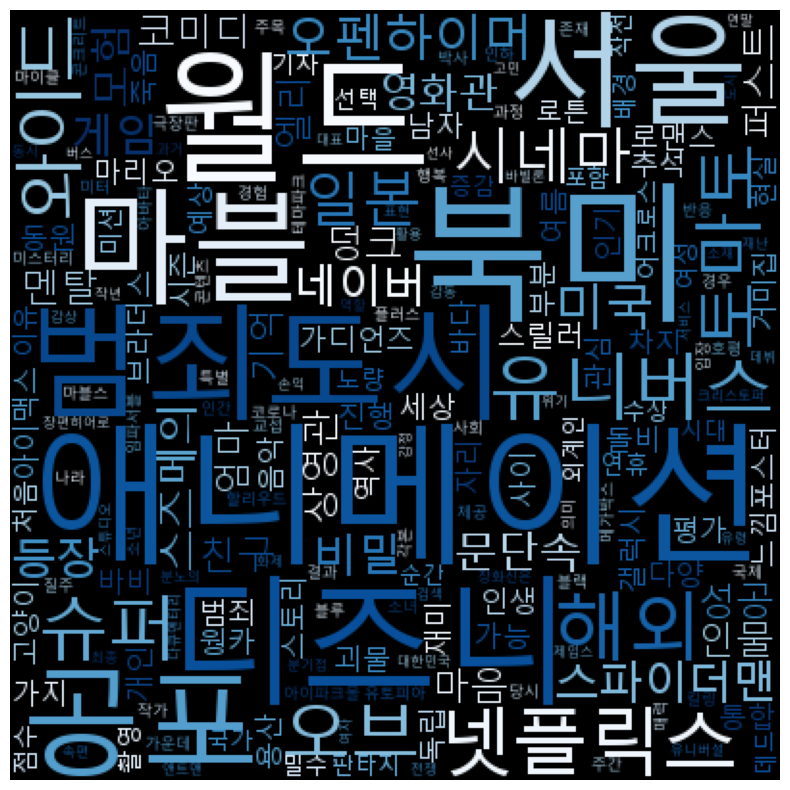

In [17]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBr': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

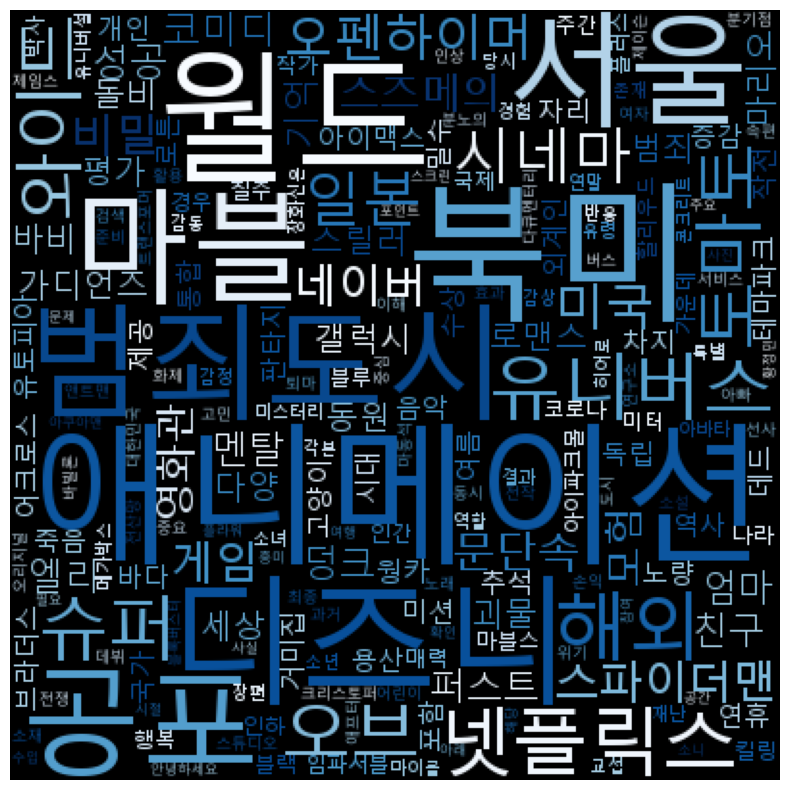

In [19]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'기자', '등장', '처음', '이유', '점수', '가지', '마음', '재미', '남자', '마을',
             '느낌', '포스터', '인물', '인생', '가능', '진행', '상영관', '부분', '시즌',
             '예상', '극장판', '콘텐츠', '시청', '작년', '등장', '스토리', '사이', '여성',
             '인기', '현실', '과정', '선택', '주목', '촬영', '의미', '관심', '호평', '사회',
             '표현', '대표', '배경', '순간', '입장'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [description WordCloud]

In [20]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_description.set_index('word').to_dict()['count']
dic_word

{'애니메이션': 31,
 '마블': 30,
 '추석': 23,
 '범죄도시': 23,
 '연말': 21,
 '서울': 20,
 '공포': 20,
 '넷플릭스': 19,
 '디즈니': 18,
 '덩크': 17,
 '슈퍼': 17,
 '미국': 16,
 '일본': 16,
 '연휴': 15,
 '교섭': 15,
 '퍼스트': 15,
 '앤트맨': 14,
 '북미': 14,
 '바비': 14,
 '멘탈': 14,
 '중심': 13,
 '수상자': 13,
 '스즈메의': 13,
 '문단속': 13,
 '시네마': 13,
 '노량': 13,
 '국가': 13,
 '가운데': 13,
 '와스프': 13,
 '엘리': 13,
 '오펜하이머': 13,
 '연구소': 13,
 '외화': 12,
 '스릴러': 12,
 '어린이': 12,
 '히어로': 12,
 '영화관': 12,
 '비밀': 11,
 '리스트': 11,
 '오브': 11,
 '마블스': 11,
 '캡틴': 11,
 '외국': 11,
 '시놉시스': 11,
 '마음': 11,
 '모험': 10,
 '매니아': 10,
 '바다': 10,
 '판타지': 10,
 '갤럭시': 10,
 '퇴마': 10,
 '가디언즈': 10,
 '브라더스': 10,
 '코미디': 10,
 '스위치': 10,
 '박사': 10,
 '대한민국': 10,
 '애프터': 10,
 '밀수': 10,
 '퀀텀': 10,
 '미스터리': 10,
 '새해': 10,
 '스코어': 10,
 '국제': 9,
 '여름': 9,
 '네이버': 9,
 '죽음': 9,
 '로맨스': 9,
 '월드': 9,
 '단독': 9,
 '범죄': 9,
 '흥행작': 9,
 '웡카': 9,
 '포함': 8,
 '설경': 8,
 '비평가': 8,
 '질주': 8,
 '처음': 8,
 '거미집': 8,
 '해외': 8,
 '하반기': 8,
 '작년': 8,
 '유니버스': 8,
 '유령': 8,
 '아바타': 8,
 '김영식': 8,
 '동원': 8,
 '표시': 8,
 '상

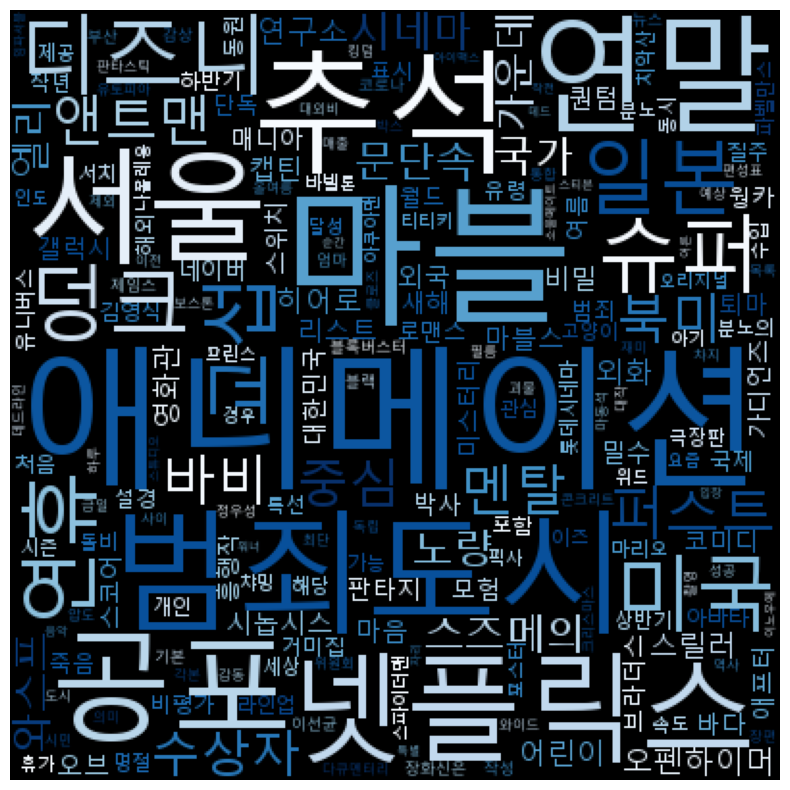

In [22]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

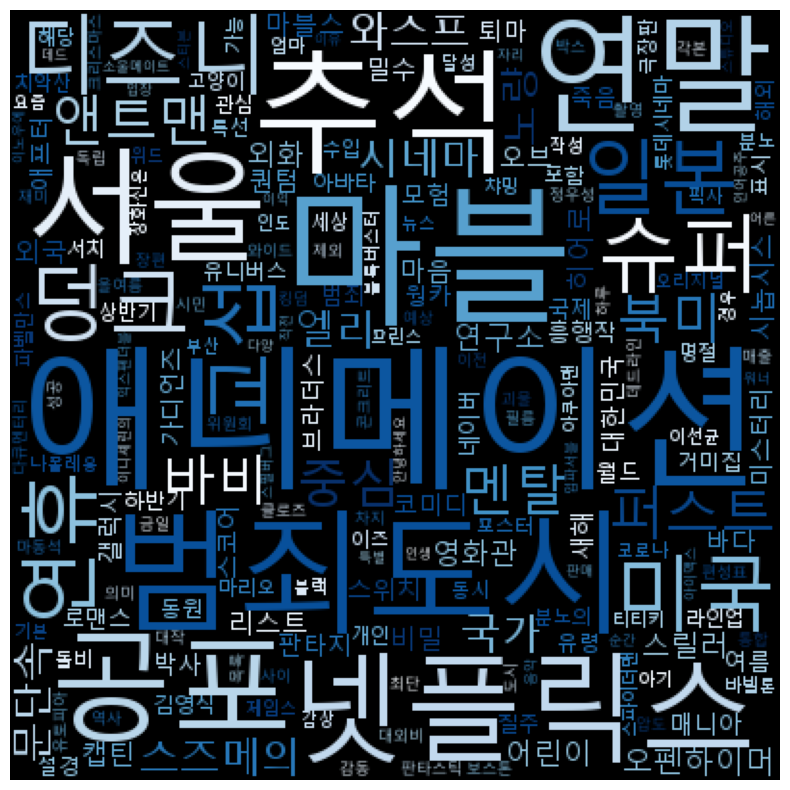

In [23]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'제공', '작년', '단독', '시즌', '처음', '휴가', '수상자', '비평가', '가운데',
             '속도'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [title WordCloud]

In [24]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_title.set_index('word').to_dict()['count']
dic_word

{'연말': 25,
 '넷플릭스': 19,
 '추석': 18,
 '북미': 18,
 '스즈메의': 16,
 '문단속': 16,
 '마블': 13,
 '서울': 13,
 '애니메이션': 11,
 '범죄도시': 11,
 '동원': 10,
 '어린이': 10,
 '연휴': 10,
 '디즈니': 10,
 '시네마': 9,
 '슈퍼': 8,
 '웡카': 8,
 '오펜하이머': 8,
 '연구소': 8,
 '박사': 8,
 '멘탈': 8,
 '공포': 7,
 '엘리': 7,
 '거미집': 7,
 '덩크': 6,
 '비밀': 6,
 '작전': 6,
 '외화': 6,
 '스릴러': 6,
 '메가박스': 6,
 '돌비': 6,
 '스코어': 6,
 '마리오': 5,
 '인생': 5,
 '스파이더맨': 5,
 '코미디': 5,
 '마블스': 5,
 '바비': 5,
 '쿠키': 5,
 '유니버스': 5,
 '가디언즈': 5,
 '외계인': 5,
 '퇴마': 5,
 '브라더스': 5,
 '어크로스': 5,
 '하반기': 5,
 '퍼스트': 5,
 '상반기': 5,
 '최단': 5,
 '편성표': 4,
 '설경': 4,
 '일본': 4,
 '범죄': 4,
 '특선': 4,
 '와이드': 4,
 '라일': 4,
 '보스톤': 4,
 '서치': 4,
 '포맷': 4,
 '본격': 4,
 '갤럭시': 4,
 '공지': 4,
 '압도': 4,
 '유령': 4,
 '외국': 4,
 '귀신': 4,
 '경신': 4,
 '월드': 4,
 '밀수': 4,
 '오브': 4,
 '영화관': 4,
 '단독': 3,
 '달성': 3,
 '분노의': 3,
 '새해': 3,
 '문재인': 3,
 '위시': 3,
 '정산': 3,
 '데드': 3,
 '게임': 3,
 '여름': 3,
 '질주': 3,
 '블록버스터': 3,
 '독립': 3,
 '칼날': 3,
 '전쟁': 3,
 '사이': 3,
 '강동원': 3,
 '로맨스': 3,
 '로비': 3,
 '충주': 3,
 '예고': 3,
 '평가': 3,
 '개미

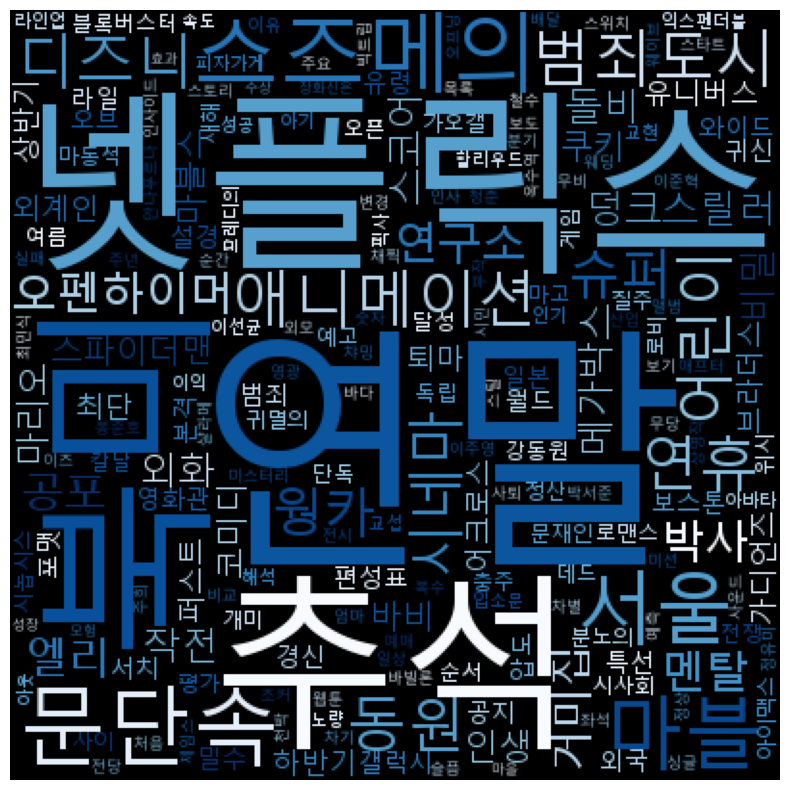

In [25]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

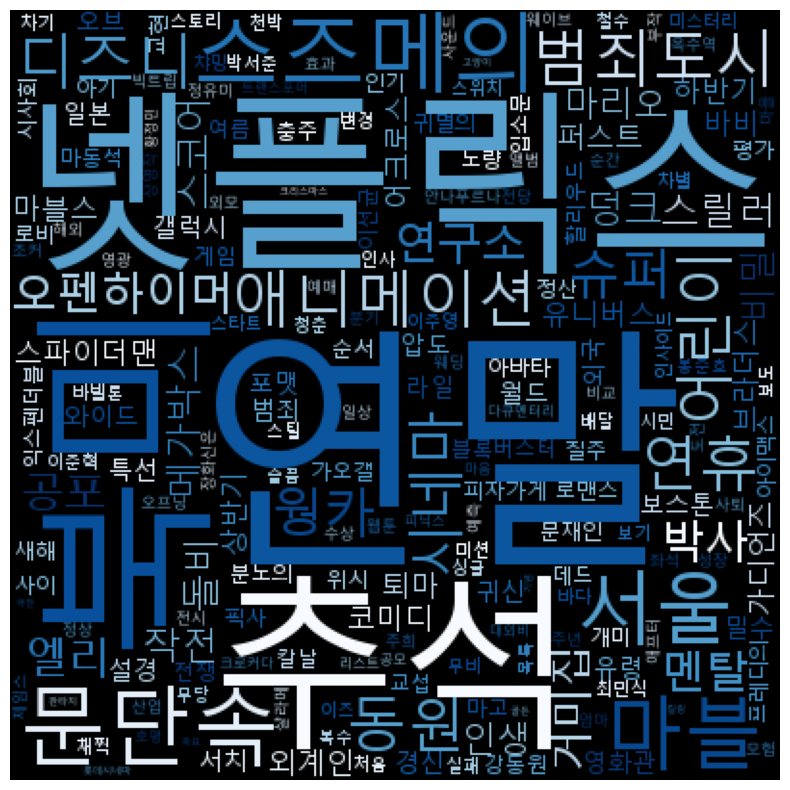

In [27]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'라인업', '최단', '아웃', '편성표', '주요', '예고', '이익', '본격', '시놉시스', 
             '쿠키', '성공', '오픈', '속도', '공지',' 인기', '해석', '달성', '단독', '독립',
             '이유', '숫자', '외화'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기